## ***GAN***

---



### ***Importing  Libraries***

In [0]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [0]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D,BatchNormalization, LeakyReLU, Flatten , Activation
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.datasets import mnist
#from tensorflow.keras.layers.advanced_activations import LeakyReLU

### ***Loading the Train and Test Data***

In [0]:
(x_train, y_train),(x_test, y_test)= mnist.load_data()   

11493376/11490434 [==============================] - 0s 0us/step


### ***Normalizing***

In [0]:
x_train = x_train/255.0                                     
x_test = x_test/255.0

In [0]:
x_train.shape 

(60000, 28, 28)

### ***Creating  Generator:***


In [0]:
def create_generator():
    #Create Encoder
    input_img = Input(shape=(28, 28, 1))    
    #Layer 1
    generator = Conv2D(100, (3, 3),padding='same')(input_img) 
    generator = BatchNormalization()(generator)
    generator = Activation('relu')(generator)

    #Layer 2  
    generator = Conv2D(50, (3, 3),padding='same')(generator)
    generator = BatchNormalization()(generator)
    generator = Activation('relu')(generator)
    
    # Create Decoder part 
    generator = Conv2D(1, (1, 1),padding='same')(generator)  
    generator = Activation('sigmoid')(generator)
    
    model = Model(inputs = input_img, outputs = generator)
    model.compile(loss='binary_crossentropy', optimizer= 'adam')
    
    return model

generate = create_generator()

generate.summary()           

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 100)       1000      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 100)       400       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 50)        45050     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 50)        200       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 50)        0     

### ***Creating Discriminator***

In [0]:
def create_discriminator():
    Inputs = Input(shape = (28,28,1))
    
    discriminator = Conv2D(256,(5,5),strides=(2,2), padding='same')(Inputs)
    discriminator = LeakyReLU(0.2)(discriminator) 
    discriminator = Dropout(0.3)(discriminator)
       
    discriminator = Conv2D(512,(5,5),strides = (2,2) ,padding = 'same')(discriminator)
    discriminator = LeakyReLU(0.2 )(discriminator) 
    discriminator = Dropout(0.3)(discriminator)

    discriminator = Flatten()(discriminator) 
       
    discriminator= Dense(units=256)(discriminator)
    discriminator= LeakyReLU(0.2)(discriminator)
    discriminator = Dropout(0.3)(discriminator)

    discriminator = Dense(units=2, activation='softmax')(discriminator)
    
    model = Model(inputs = Inputs, outputs = discriminator)
    model.compile(loss='binary_crossentropy',optimizer= 'adam')
    return model

discriminate =create_discriminator()  
discriminate.summary()             

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 256)       6656      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 512)         3277312   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 512)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 512)         0   

### ***Creating GAN***

In [0]:
def create_gan(discriminator, generator):
    discriminator.trainable=False 
    gan_input = Input(shape=(28,28, 1))        
    x = generator(gan_input)  
    gan_output= discriminator(x)  
    gan= Model(inputs=gan_input, outputs=gan_output) 
    gan.compile(loss='binary_crossentropy', optimizer='adam')                   
    return gan

gan = create_gan(discriminate,generate)
gan.summary()  

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Model)                (None, 28, 28, 1)         46701     
_________________________________________________________________
model_1 (Model)              (None, 2)                 9707266   
Total params: 9,753,967
Trainable params: 46,401
Non-trainable params: 9,707,566
_________________________________________________________________


In [0]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 28,28,1])               
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1,28,28)                      
    plt.figure(figsize=figsize) 
    for i in range(generated_images.shape[0]):                                   
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i].reshape(28,28), interpolation='nearest')  
        plt.axis('off') 
    plt.tight_layout()    
    plt.savefig('gan_generated_image %d.png' %epoch)  

In [0]:
from tqdm import tqdm                                     

### ***MODEL TRAINING***

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 2


100%|██████████| 128/128 [20:43<00:00,  9.72s/it]


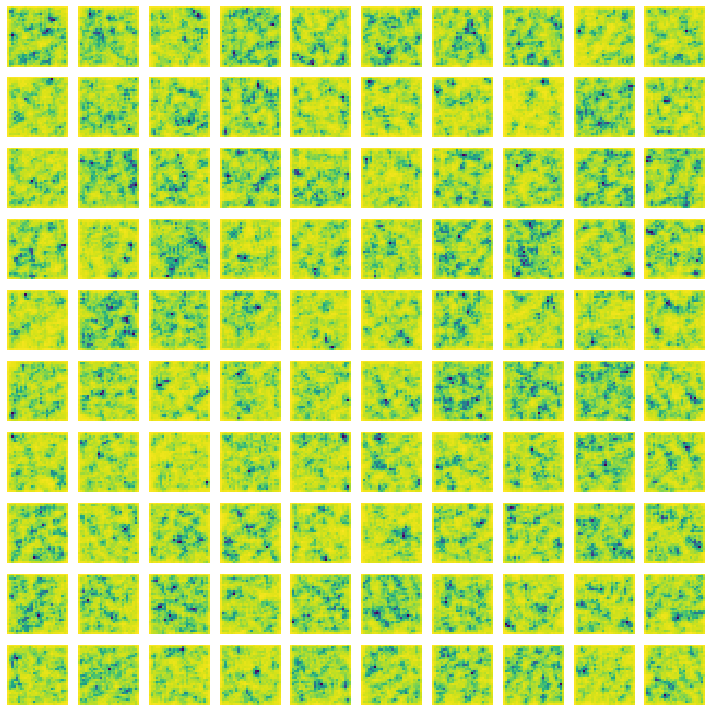

In [0]:
def training(epochs=1, batch_size=128): 
    
    # Creating GAN 
    generator= create_generator()
    discriminator= create_discriminator()                                       
    gan = create_gan(discriminator, generator)    
    

    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)  
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 28,28,1]) 
                    
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)           
            generated_images = generated_images.reshape(-1, 28,28) 
            
            # Get a random set of  real images
            image_batch =x_train[np.random.randint(low=0,high=x_train.shape[0],size=batch_size)]
             
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])  
            
            # Labels for generated and real data                                
            y_dis=np.zeros(2*batch_size)                
            y_dis[:batch_size]=0.9                                              
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True 
            discriminator.train_on_batch(X, y_dis)                              
            
            #Tricking the noised input of the Generator as real data            
            noise= np.random.normal(0,1, [batch_size, 28,28,1])
            y_gen = np.ones(batch_size)   
            
            # During the training of gan,                   
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False 
             
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)    
             
        if e == 1 or e % 20 == 0:                         
            
            plot_generated_images(e, generator)   
             
training(2,128)  #training for only 2 epochs

### ***Above is the result for training only for two EPOCHS***

---

